In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
import numpy as np

import sys
import argparse
import neurokit2 as nk
import json
import scipy
from datetime import datetime

import random

In [4]:
# Initialize a variable with the current directory
directory = os.getcwd()

# Create a list to store the directory names
directories = [directory]

# Navigate up the directory tree and store names in the list
while True:
    directory, tail = os.path.split(directory)
    if not tail:
        break
    directories.append(directory)

# Get directories we want
current_directory = directories[0]
dev_directory = directories[2]

# Set the path to the database directory with hdf5 files
shared_dir = directories[-3]
database = 'Database - ECG'
db_directory = os.path.join(shared_dir, database)

# Set the path to the data directory destination (where to save the extracted files)
data_subdirectory = 'input\\ECG_db_new'
data_directory = os.path.join(dev_directory, data_subdirectory)

# Print the directories neatly
print("Current Directory:", current_directory)
print("Dev Directory:", dev_directory)
print("Database Directory", db_directory)
print("Destination Data Directory", data_directory)

Current Directory: x:\GDrive\Shared drives\Project - NeRF ILR to ECG\dev\notebooks\modeling\ConvexECG
Dev Directory: x:\GDrive\Shared drives\Project - NeRF ILR to ECG\dev\notebooks
Database Directory x:\GDrive\Shared drives\Database - ECG
Destination Data Directory x:\GDrive\Shared drives\Project - NeRF ILR to ECG\dev\notebooks\input\ECG_db_new


In [5]:
ppg_path = "X:\ppg_exports_2024\metadata_cleaned.csv"
ppg_df = pd.read_csv(ppg_path)

In [6]:
import pandas as pd
import os

# Drop the unnecessary column if it exists
ppg_df = ppg_df.drop(columns=['Unnamed: 15'], errors='ignore')

# Classify filenames based on their pattern
def classify_filename(filename):
    if isinstance(filename, str):
        if filename.startswith('afib'):
            return 'afib'
        elif filename.startswith('irregular'):
            return 'irregular'
        elif filename.startswith('regular'):
            return 'regular'
        else:
            return 'unclassified'
    return 'unclassified'

# Create a new column for classification
ppg_df['filename_type'] = ppg_df['filename'].apply(classify_filename)

# Count the occurrences of each filename type from the dataframe
filename_counts = ppg_df['filename_type'].value_counts()

# Check total rows in dataframe
print(f"Total rows in dataframe: {len(ppg_df)}")

# Check number of files in directories
folders = ['afib', 'irregular', 'regular', 'unclassified']
base_path = r"X:\\ppg_exports_2024"
folder_counts = {}

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        folder_counts[folder] = len([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    else:
        folder_counts[folder] = 0

print("\nFile Counts from Directories:")
for folder, count in folder_counts.items():
    print(f"{folder.capitalize()} folder: {count} files")

print("\nFilename Type Counts from DataFrame:")
print(filename_counts)

# Compare results
print("\nComparison of Directory vs DataFrame Counts:")
for folder in folders:
    dir_count = folder_counts.get(folder, 0)
    df_count = filename_counts.get(folder, 0)
    print(f"{folder.capitalize()}: Directory = {dir_count}, DataFrame = {df_count}")

Total rows in dataframe: 2972

File Counts from Directories:
Afib folder: 1053 files
Irregular folder: 968 files
Regular folder: 997 files
Unclassified folder: 99 files

Filename Type Counts from DataFrame:
filename_type
afib         1053
regular       967
irregular     952
Name: count, dtype: int64

Comparison of Directory vs DataFrame Counts:
Afib: Directory = 1053, DataFrame = 1053
Irregular: Directory = 968, DataFrame = 952
Regular: Directory = 997, DataFrame = 967
Unclassified: Directory = 99, DataFrame = 0


In [7]:
import pandas as pd
import os

# Drop the unnecessary column if it exists
ppg_df = ppg_df.drop(columns=['Unnamed: 15'], errors='ignore')

# Classify filenames based on their pattern
def classify_filename(filename):
    if isinstance(filename, str):
        if filename.startswith('afib'):
            return 'afib'
        elif filename.startswith('irregular'):
            return 'irregular'
        elif filename.startswith('regular'):
            return 'regular'
        else:
            return 'unclassified'
    return 'unclassified'

# Create a new column for classification
ppg_df['filename_type'] = ppg_df['filename'].apply(classify_filename)

# Collect all directory filenames
base_path = r"X:\\ppg_exports_2024"
all_directory_files = set()
folders = ['afib', 'irregular', 'regular', 'unclassified']
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        all_directory_files.update(f for f in os.listdir(folder_path) if f.endswith('.csv'))

# Filter dataframe to remove rows without matching files and unclassified types
ppg_df = ppg_df[(ppg_df['filename'].isin(all_directory_files)) & (ppg_df['filename_type'] != 'unclassified')]

# Display results after filtering
print(f"Filtered dataframe row count: {len(ppg_df)}")
print("Filename type counts after filtering:")
print(ppg_df['filename_type'].value_counts())

Filtered dataframe row count: 2972
Filename type counts after filtering:
filename_type
afib         1053
regular       967
irregular     952
Name: count, dtype: int64


In [8]:
ppg_df.head()

,sinus,bradycardia,tachycardia,brady_episode,increased_hrv,tachy_episode,atrial_flutter,atrial_fibrillation,extrasystoles_bigminy,extrasystoles_frequent,extrasystoles_isolated,extrasystoles_trigeminy,extrasystoles_big_episode,extrasystoles_trig_episode,filename,filename_type
0,0.792743,0.010405,0.012852,0.009979,0.046365,0.013038,0.012176,0.011995,0.011067,0.009181,0.037293,0.011029,0.010773,0.011105,regular_1.csv,regular
1,0.302839,0.009541,0.012640,0.010040,0.545251,0.012761,0.008074,0.006429,0.008243,0.010104,0.048075,0.008127,0.009295,0.008582,regular_2.csv,regular
2,0.569893,0.012372,0.013917,0.013252,0.228312,0.015489,0.010631,0.012475,0.011948,0.013415,0.062736,0.011165,0.012777,0.011620,regular_3.csv,regular
3,0.825582,0.010987,0.013214,0.012482,0.012836,0.011228,0.013625,0.010001,0.013409,0.010215,0.028495,0.013385,0.011172,0.013370,regular_4.csv,regular
4,0.442336,0.006235,0.007689,0.023287,0.271213,0.107267,0.006277,0.011201,0.005997,0.011480,0.082505,0.008485,0.008647,0.007381,regular_5.csv,regular


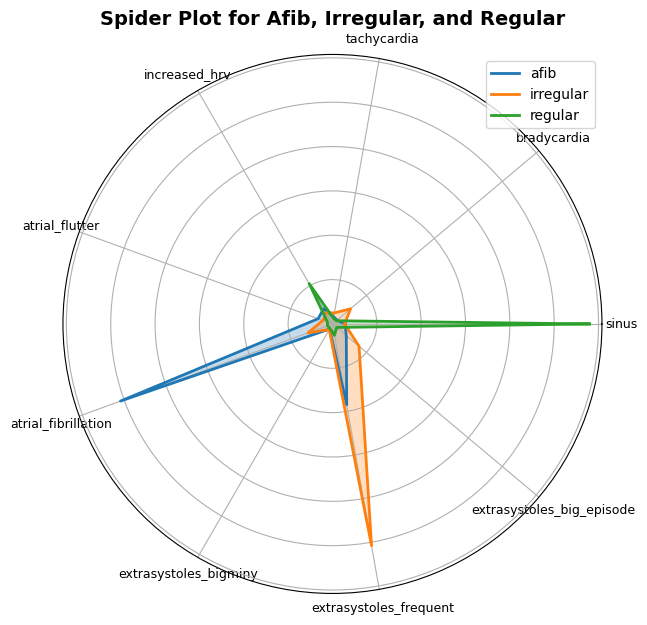

Minimum atrial_fibrillation threshold for Afib classification: 0.005545323


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Selected features for spider plot
features = [
    'sinus', 'bradycardia', 'tachycardia', 'increased_hrv',
    'atrial_flutter', 'atrial_fibrillation',
    'extrasystoles_bigminy', 'extrasystoles_frequent', 'extrasystoles_big_episode'
]

# Calculate mean values for each group (afib, irregular, regular)
mean_values = ppg_df.groupby('filename_type')[features].mean()

# Spider plot function
def plot_spider(data, title):
    labels = np.array(features)
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]
    
    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)
    
    for group, values in data.iterrows():
        stats = values.tolist()
        stats += stats[:1]
        ax.plot(angles, stats, label=group, linewidth=2)
        ax.fill(angles, stats, alpha=0.25)
    
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    plt.show()

# Plot spider charts for afib, irregular, and regular
afib_irregular_regular = mean_values.loc[['afib', 'irregular', 'regular']]
plot_spider(afib_irregular_regular, 'Spider Plot for Afib, Irregular, and Regular')

# Determine the minimum threshold for atrial_fibrillation in afib rows
afib_min_threshold = ppg_df.loc[ppg_df['filename_type'] == 'afib', 'atrial_fibrillation'].min()
print(f"Minimum atrial_fibrillation threshold for Afib classification: {afib_min_threshold}")

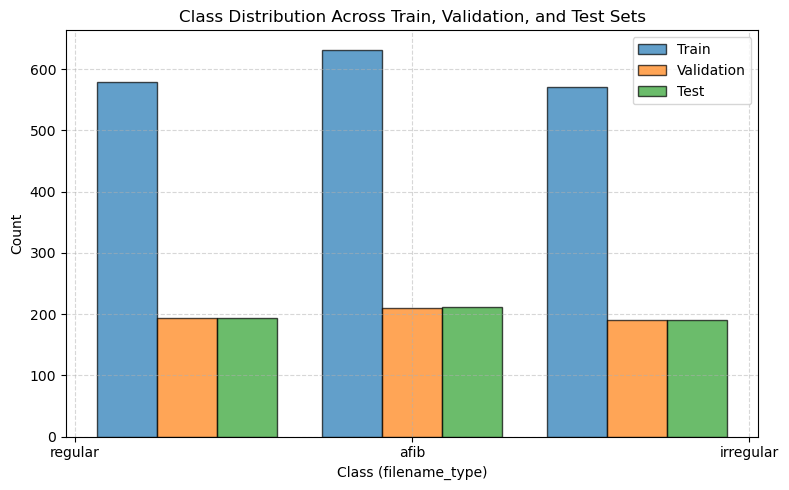

Train Class Distribution:
filename_type
afib         632
regular      580
irregular    571
Name: count, dtype: int64

Validation Class Distribution:
filename_type
afib         210
regular      193
irregular    191
Name: count, dtype: int64

Test Class Distribution:
filename_type
afib         211
regular      194
irregular    190
Name: count, dtype: int64


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Train-test-val split for the three classes from ppg_df
train_df, temp_df = train_test_split(ppg_df, test_size=0.4, stratify=ppg_df['filename_type'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['filename_type'], random_state=42)

# Plot class distribution histogram
plt.figure(figsize=(8, 5))
plt.hist([train_df['filename_type'], val_df['filename_type'], test_df['filename_type']], 
         label=['Train', 'Validation', 'Test'], alpha=0.7, bins=3, edgecolor='black')

plt.xlabel('Class (filename_type)')
plt.ylabel('Count')
plt.title('Class Distribution Across Train, Validation, and Test Sets')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Display counts for reference
print("Train Class Distribution:")
print(train_df['filename_type'].value_counts())
print("\nValidation Class Distribution:")
print(val_df['filename_type'].value_counts())
print("\nTest Class Distribution:")
print(test_df['filename_type'].value_counts())


In [11]:
import pandas as pd
import numpy as np
import os
import neurokit2 as nk
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# First split the dataframe into train/val/test 
train_df, temp_df = train_test_split(ppg_df, test_size=0.4, stratify=ppg_df['filename_type'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['filename_type'], random_state=42)

def process_single_file(filename, file_type, root_folder):
    try:
        # Load and process file
        file_path = os.path.join(root_folder, file_type, filename)
        df = pd.read_csv(file_path).iloc[:1500]
        df['green'] = zscore(df['green'])
        
        # Process with Neurokit and convert to numpy
        signals, _ = nk.ppg_process(df['green'], sampling_rate=25)
        return signals['PPG_Clean'].to_numpy()
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

# Process files and create X, y for each set
def create_dataset(df, root_folder, desc):
    X = []
    y = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=desc):
        signal = process_single_file(row['filename'], row['filename_type'], root_folder)
        if signal is not None:
            X.append(signal)
            # Binary classification: regular vs non-regular
            y.append(0 if row['filename_type'] == 'regular' else 1)
    
    return np.array(X), np.array(y)

# Create datasets
root_folder = r"X:\\ppg_exports_2024"
X_train, y_train = create_dataset(train_df, root_folder, "Processing training set") 
X_val, y_val = create_dataset(val_df, root_folder, "Processing validation set") 
X_test, y_test = create_dataset(test_df, root_folder, "Processing test set") 

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Print class distribution
print("\nClass distribution:")
print("Training set:", np.bincount(y_train), "(0=regular, 1=non-regular)")
print("Validation set:", np.bincount(y_val), "(0=regular, 1=non-regular)")
print("Test set:", np.bincount(y_test), "(0=regular, 1=non-regular)")

# Print unique filename types to verify our classification
print("\nUnique filename types in dataset:")
print(ppg_df['filename_type'].unique())

Processing test set: 100%|██████████| 595/595 [00:18<00:00, 32.53it/s]

Training set shape: (1783, 1500), (1783,)
Validation set shape: (594, 1500), (594,)
Test set shape: (595, 1500), (595,)

Class distribution:
Training set: [ 580 1203] (0=regular, 1=non-regular)
Validation set: [193 401] (0=regular, 1=non-regular)
Test set: [194 401] (0=regular, 1=non-regular)

Unique filename types in dataset:
['regular' 'irregular' 'afib']


In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns
import torch.cuda.amp as amp


# --- Data Preparation ---
# Reshape X data to have an extra dimension for the feature channel
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # shape: (samples, 1500, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)                 # y_train is already numpy
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)    # shape: (samples, 1500, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)                  # y_test is already numpy

# Also should include validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)      # shape: (samples, 1500, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

class CNN1DClassifier(nn.Module):
    def __init__(self, in_channels=1, dropout=0.1):
        super(CNN1DClassifier, self).__init__()
        
        # Example: two convolutional layers
        self.conv1 = nn.Conv1d(in_channels, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        # AdaptiveMaxPool1d(1) squeezes the time dimension down to 1,
        # so the output shape will be [batch_size, 32].
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)
        
        # Final fully connected layer to get a single logit
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        """
        x is assumed to be of shape [batch_size, seq_len, 1].
        We permute to [batch_size, 1, seq_len] for Conv1d.
        """
        x = x.permute(0, 2, 1)  # -> [batch_size, 1, 1500]
        
        # Convolution block 1
        x = self.conv1(x)       # -> [batch_size, 16, 1500]
        x = self.bn1(x)
        x = self.relu(x)
        
        # Convolution block 2
        x = self.conv2(x)       # -> [batch_size, 32, 1500]
        x = self.bn2(x)
        x = self.relu(x)
        
        # Global max pooling to reduce the time dimension
        x = self.pool(x)        # -> [batch_size, 32, 1]
        x = x.view(x.size(0), -1)  # -> [batch_size, 32]
        
        x = self.dropout(x)
        out = self.fc(x)        # -> [batch_size, 1]

        # Return a single logit per sample (no sigmoid, since we'll use BCEWithLogitsLoss)
        return out.squeeze()


# --- Model, Optimizer, and Loss Function ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1DClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # Changed from BCELoss to BCEWithLogitsLoss
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scaler = amp.GradScaler()


# --- Training Loop ---
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # Wrap training step in autocast
        with amp.autocast():
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
        
        # Scale the loss and call backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# --- Evaluation ---
model.eval()
y_pred = []
y_true = []
y_proba = []

with torch.no_grad(), amp.autocast():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)  # Add sigmoid here for probabilities
        y_proba.extend(probs.cpu().numpy())
        y_pred.extend((probs.cpu().numpy() > 0.5).astype(int))
        y_true.extend(y_batch.cpu().numpy())

Epoch 1/20, Loss: 0.7063
Epoch 2/20, Loss: 0.5142
Epoch 3/20, Loss: 0.5048
Epoch 4/20, Loss: 0.4965
Epoch 5/20, Loss: 0.4717
Epoch 6/20, Loss: 0.4700
Epoch 7/20, Loss: 0.4705
Epoch 8/20, Loss: 0.4830
Epoch 9/20, Loss: 0.4367
Epoch 10/20, Loss: 0.4963
Epoch 11/20, Loss: 0.4737
Epoch 12/20, Loss: 0.4512
Epoch 13/20, Loss: 0.4374
Epoch 14/20, Loss: 0.4416
Epoch 15/20, Loss: 0.4523
Epoch 16/20, Loss: 0.4397
Epoch 17/20, Loss: 0.4571
Epoch 18/20, Loss: 0.4415
Epoch 19/20, Loss: 0.4234
Epoch 20/20, Loss: 0.4355


In [14]:
print(model)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)


CNN1DClassifier(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveMaxPool1d(output_size=1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
Number of trainable parameters: 2817


Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.75      0.72       194
         1.0       0.87      0.83      0.85       401

    accuracy                           0.81       595
   macro avg       0.78      0.79      0.79       595
weighted avg       0.81      0.81      0.81       595



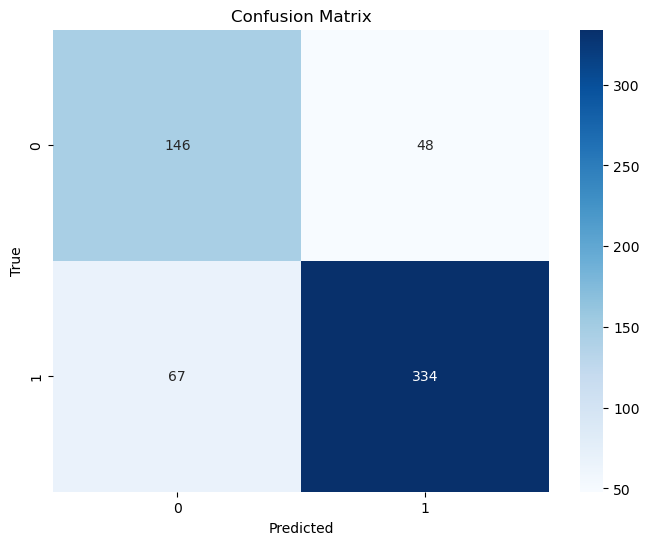

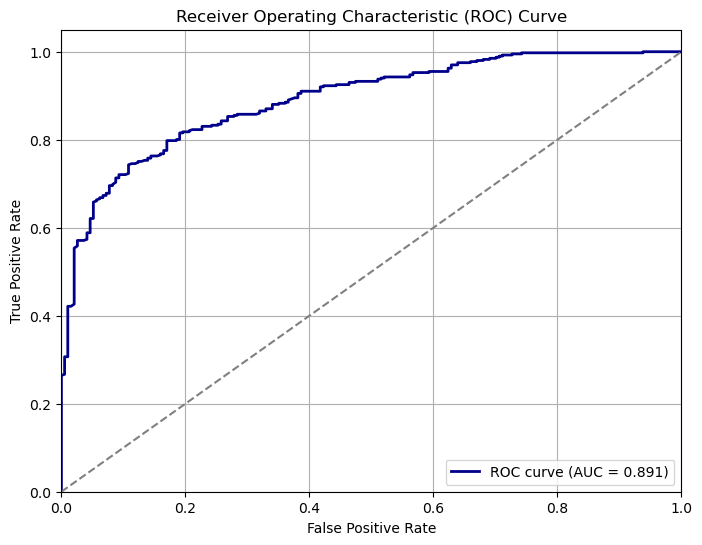


Detailed Metrics:
Accuracy: 0.807
Precision: 0.874
Recall: 0.833
F1 Score: 0.853
ROC AUC: 0.891


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# Calculate and print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\nDetailed Metrics:")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
print(f"Precision: {precision_score(y_true, y_pred):.3f}")
print(f"Recall: {recall_score(y_true, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

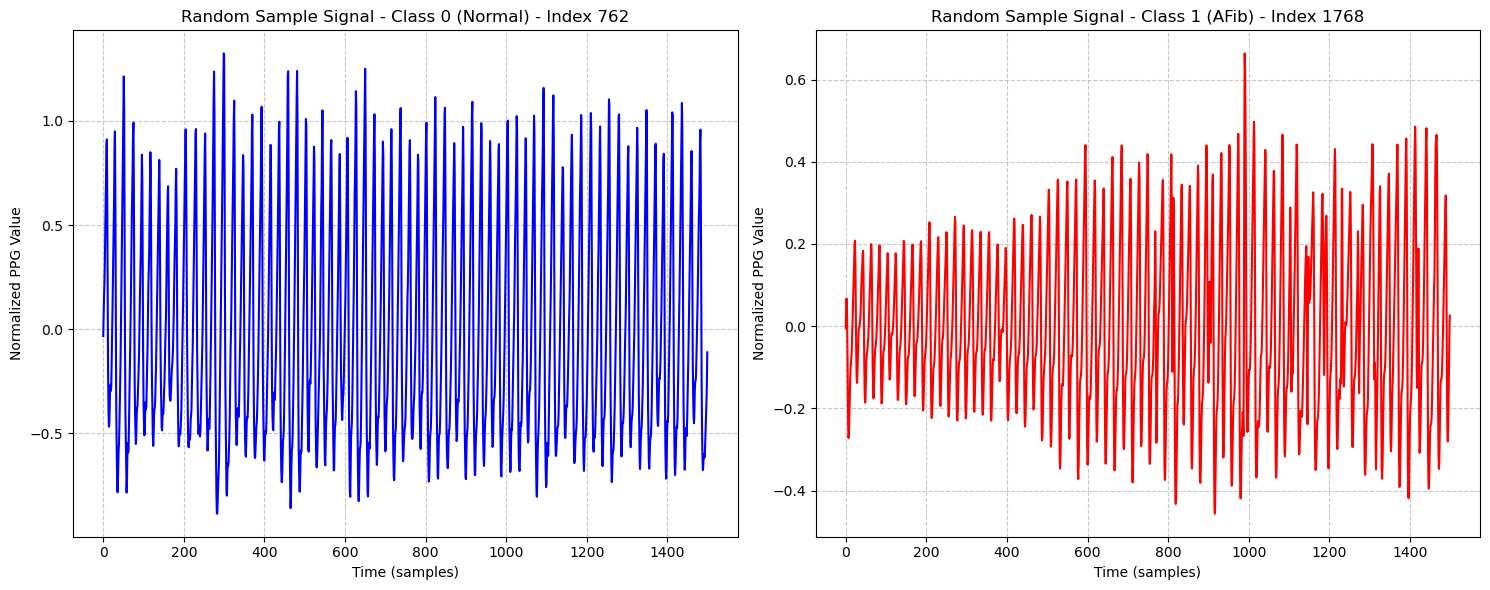

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Ensure compatibility with the new data preparation (samples, 1500, 1)
if X_train_tensor.dim() != 3 or X_train_tensor.shape[-1] != 1:
    raise ValueError("X_train_tensor must have shape (samples, 1500, 1) for compatibility with the LSTM.")

# Randomly select examples from each class
class_0_indices = (y_train_tensor == 0).nonzero(as_tuple=True)[0]
class_1_indices = (y_train_tensor == 1).nonzero(as_tuple=True)[0]

if len(class_0_indices) == 0 or len(class_1_indices) == 0:
    raise ValueError("Both classes must have at least one sample in the training data.")

idx_0 = random.choice(class_0_indices).item()
idx_1 = random.choice(class_1_indices).item()

# Extract signals and labels
signal_0 = X_train_tensor[idx_0].squeeze().numpy()
signal_1 = X_train_tensor[idx_1].squeeze().numpy()

# Plot the signals side by side
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(signal_0, color='blue')
plt.title(f"Random Sample Signal - Class 0 (Normal) - Index {idx_0}")
plt.xlabel('Time (samples)')
plt.ylabel('Normalized PPG Value')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(signal_1, color='red')
plt.title(f"Random Sample Signal - Class 1 (AFib) - Index {idx_1}")
plt.xlabel('Time (samples)')
plt.ylabel('Normalized PPG Value')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [17]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train SVM with more verbose output and different parameters
svm = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')

print("Fitting SVM...")
svm.fit(X_train_scaled, y_train)

# Get predictions for all sets
train_pred = svm.predict(X_train_scaled)
val_pred = svm.predict(X_val_scaled)
test_pred = svm.predict(X_test_scaled)

# Print predictions distribution for each set
print("\nPrediction distributions:")
print("Train:", np.bincount(train_pred), f"({len(train_pred)} total)")
print("Val:", np.bincount(val_pred), f"({len(val_pred)} total)")
print("Test:", np.bincount(test_pred), f"({len(test_pred)} total)")

# Look at probabilities to see if they're all similar
train_probs = svm.predict_proba(X_train_scaled)[:, 1]
print("\nProbability statistics for class 1:")
print("Min prob:", train_probs.min())
print("Max prob:", train_probs.max())
print("Mean prob:", train_probs.mean())
print("Sample of probabilities:", train_probs[:10])

# Print detailed performance
print("\nTraining set performance:")
print(classification_report(y_train, train_pred))

Fitting SVM...

Prediction distributions:
Train: [ 583 1200] (1783 total)
Val: [152 442] (594 total)
Test: [148 447] (595 total)

Probability statistics for class 1:
Min prob: 0.6222592071442015
Max prob: 0.7302800085036002
Mean prob: 0.6748751203108463
Sample of probabilities: [0.62807076 0.67558151 0.67889488 0.66968993 0.70398235 0.69912257
 0.66663358 0.68197259 0.69645006 0.62803755]

Training set performance:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       580
           1       0.92      0.92      0.92      1203

    accuracy                           0.90      1783
   macro avg       0.88      0.88      0.88      1783
weighted avg       0.90      0.90      0.90      1783



Test set performance:
              precision    recall  f1-score   support

           0       0.43      0.33      0.37       194
           1       0.71      0.79      0.75       401

    accuracy                           0.64       595
   macro avg       0.57      0.56      0.56       595
weighted avg       0.62      0.64      0.63       595



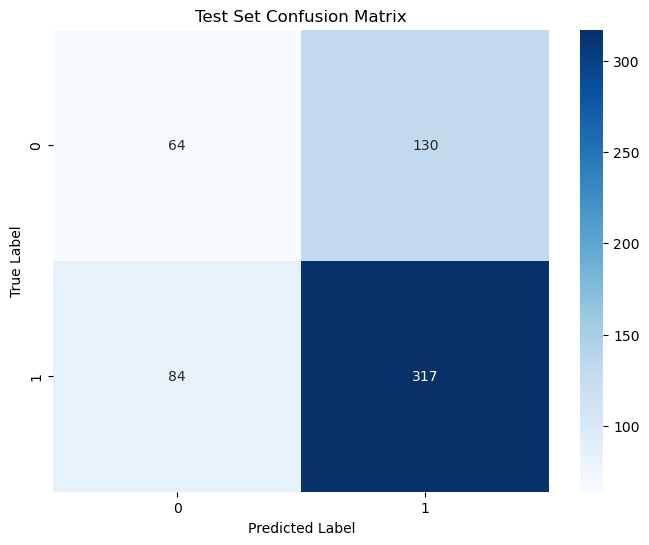

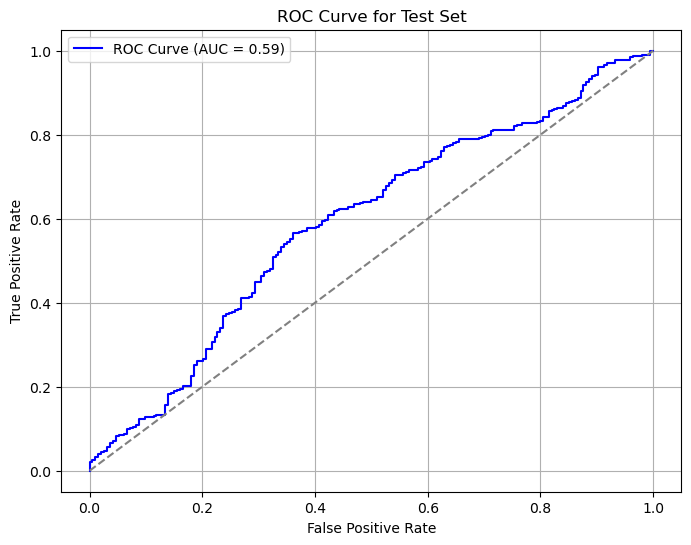


Probability statistics for test set:
Min prob: 0.6229677889844035
Max prob: 0.7246285915056306
Mean prob: 0.6740854841500188


In [18]:
# Get test set predictions and performance
test_pred = svm.predict(X_test_scaled)
test_probs = svm.predict_proba(X_test_scaled)[:, 1]

# Print detailed test performance
print("Test set performance:")
print(classification_report(y_test, test_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend()
plt.grid(True)
plt.show()

print("\nProbability statistics for test set:")
print("Min prob:", test_probs.min())
print("Max prob:", test_probs.max())
print("Mean prob:", test_probs.mean())

In [19]:
import torch 
# Check if PyTorch recognizes the GPU
if torch.cuda.is_available():
    print("\nPyTorch recognizes the GPU!")
    print("Current Device:", torch.cuda.current_device())
    print("Device Count:", torch.cuda.device_count())
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("\nPyTorch doesn't recognize any GPU.")

# Print PyTorch and CUDA versions
print("\nPyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)


PyTorch recognizes the GPU!
Current Device: 0
Device Count: 1
Device Name: NVIDIA GeForce RTX 4090

PyTorch Version: 2.3.1+cu121
CUDA Version: 12.1


In [94]:
# Find top 5 bradycardia indices
brady_top5 = ppg_df['bradycardia'].sort_values(ascending=False).head(5)
print("Top 5 Bradycardia Indices:")
print(brady_top5.index.tolist())
print("\nBradycardia values:")
print(brady_top5.values.tolist())

# Find top 5 tachycardia indices
tachy_top5 = ppg_df['tachycardia'].sort_values(ascending=False).head(5)
print("\nTop 5 Tachycardia Indices:")
print(tachy_top5.index.tolist())
print("\nTachycardia values:")
print(tachy_top5.values.tolist())

Top 5 Bradycardia Indices:
[1816, 1284, 1847, 1297, 1853]

Bradycardia values:
[0.981911004, 0.980447412, 0.975273907, 0.97465682, 0.971157312]

Top 5 Tachycardia Indices:
[1522, 1440, 1501, 1630, 1166]

Tachycardia values:
[0.950393677, 0.947268903, 0.94004941, 0.939630628, 0.928677678]


In [21]:
import pandas as pd
import os

# Root folder path (Windows compatible)
root_folder = r"X:\\ppg_exports_2024"

# Pick a row from ppg_df and get the filename and type
sample_row = ppg_df.iloc[23]
sample_filename = sample_row['filename']
sample_type = sample_row['filename_type']

# Construct path through the subfolder based on filename type
file_path = os.path.join(root_folder, sample_type, sample_filename)

# Try loading the CSV and display its shape
try:
    sample_df = pd.read_csv(file_path)
    print(f"Loaded file: {file_path}")
    print(f"Shape of the loaded file: {sample_df.shape}")
except FileNotFoundError:
    print(f"File not found: {file_path}")
except Exception as e:
    print(f"Error loading file: {e}")

Loaded file: X:\\ppg_exports_2024\regular\regular_24.csv
Shape of the loaded file: (1518, 7)


c:\Users\Rayan\.conda\envs\ILR\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Extracted PPG Features:
   PPG_Rate_Mean  HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0     120.833334  496.896552  55.668407         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD  ...  HRV_SampEn  HRV_ShanEn  \
0         NaN         NaN         NaN  60.524027  ...    1.871802    3.361257   

   HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD   HRV_HFD   HRV_KFD  \
0     1.605278  0.768944        0.0         0.0  1.402485  1.937146  3.705408   

    HRV_LZC  
0  1.312996  

[1 rows x 83 columns]
Associated Key Features from ppg_df (Row 0):
sinus                        0.046409
bradycardia                  0.004817
tachycardia                  0.005863
increased_hrv                0.728221
atrial_flutter               0.004314
atrial_fibrillation          0.004046
extrasystoles_bigminy        0.004529
extrasystoles_frequent       0.083056
extrasystoles_big_episode    0.004592
Name: 23, dtype: object


<Figure size 1500x600 with 0 Axes>

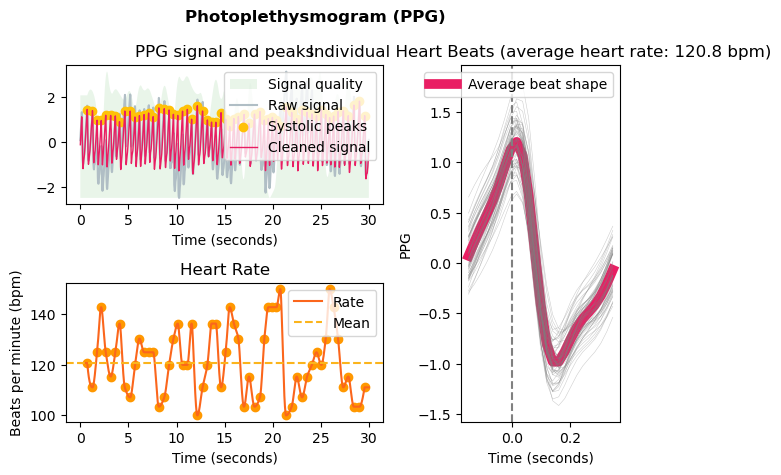

In [22]:
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Set the figure size before plotting
plt.figure(figsize=(15, 6))  # Width: 15 inches, Height: 6 inches

# Trim the signal to 1500 samples (30 seconds at 50 Hz)
sample_df = sample_df.iloc[:1500]

# Z-score normalize the Green PPG signal
sample_df['green'] = zscore(sample_df['green'])

# Process PPG using NeuroKit2
signals, info = nk.ppg_process(sample_df['green'], sampling_rate=50)

# Analyze PPG features
ppg_features = nk.ppg_analyze(signals, sampling_rate=50)
print("Extracted PPG Features:")
print(ppg_features)

# Retrieve associated key features from ppg_df for this signal (row 0)
features = [
    'sinus', 'bradycardia', 'tachycardia', 'increased_hrv',
    'atrial_flutter', 'atrial_fibrillation',
    'extrasystoles_bigminy', 'extrasystoles_frequent', 'extrasystoles_big_episode'
]
associated_features = ppg_df.loc[23, features]
print("Associated Key Features from ppg_df (Row 0):")
print(associated_features)

# Plot PPG signal with extracted features using NeuroKit2
nk.ppg_plot(signals, info)

# Adjust layout to prevent any cutoff
plt.tight_layout()
plt.show()